In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from typing import Tuple, Optional
from simulation_backend import Person, Scenario

plt.style.use('ggplot')

In [2]:
sims_per_scenario = 50
T = 7*16
T_control = 7*12

In [3]:
def test_scenario(rho: float,
                  R_0: Optional[float] = 2.5,
                  initial_cases: Optional[int] = 20, 
                  onset_to_isolation: Optional[str] = "short", 
                  transmission_before_symptoms_percentage: Optional[int] = 15, 
                  subclinical_prob: Optional[float] = 0) -> Tuple[float, float]:
    """
    Function runs scenario with given parameters sims_per_scenario times. Default parameters are the baseline scenario. 

    Returns
    -------
    Tuple[float, float]
        Ratio of controlled outbreaks and average number of infections between T_control and T.

    """
    cases_in_control = []
    for _ in range(sims_per_scenario):
        scen = Scenario(
                T=T,
                T_control=T_control,
                initial_cases=initial_cases,
                rho=rho,
                R_0=R_0,
                subclinical_prob=subclinical_prob,
                transmission_before_symptoms_percentage=transmission_before_symptoms_percentage,
                onset_to_isolation=onset_to_isolation,
            )
        scen.simulate()
        cases_in_control.append(scen.cases_in_control)
        # print(_)
    average_cases_in_control = sum(cases_in_control)/sims_per_scenario
    average_controlled_outbreaks = sum(1 for c in cases_in_control if c == 0)/sims_per_scenario
    return average_controlled_outbreaks, average_cases_in_control

In [4]:
rhos = np.linspace(0.6, 1, num=3)
list(rhos)

[0.6, 0.8, 1.0]

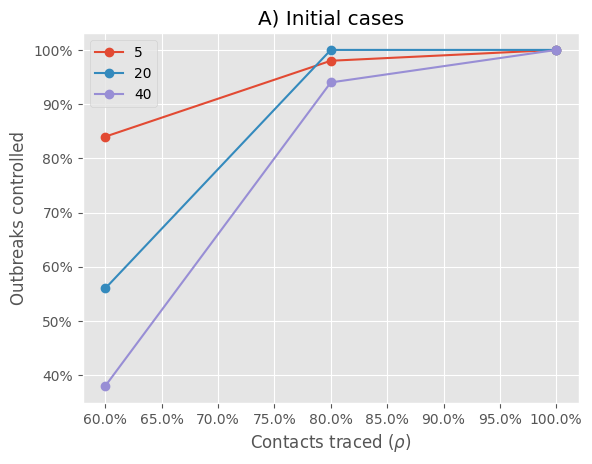

In [5]:
fig, ax = plt.subplots(1)

for initial_cases in [5, 20, 40]:
    average_controlled_outbreaks = []
    for rho in rhos:
        average_controlled_outbreaks.append(test_scenario(rho, initial_cases=initial_cases)[0])
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=initial_cases)
        
plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("A) Initial cases")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

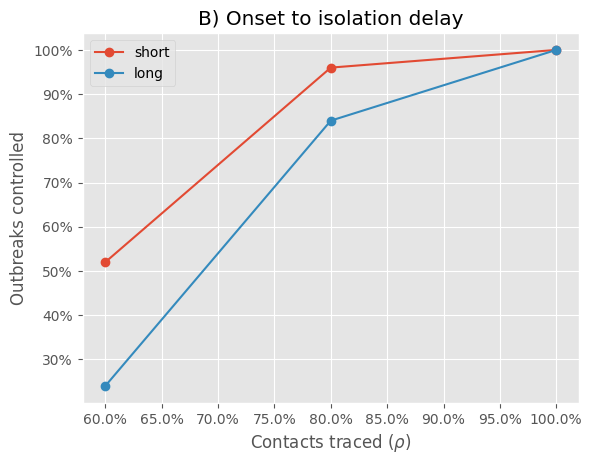

In [6]:
fig, ax = plt.subplots(1)

for onset_to_isolation in ["short", "long"]:
    average_controlled_outbreaks = []
    for rho in rhos:
        average_controlled_outbreaks.append(test_scenario(rho, onset_to_isolation=onset_to_isolation)[0])
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=onset_to_isolation)

plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("B) Onset to isolation delay")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

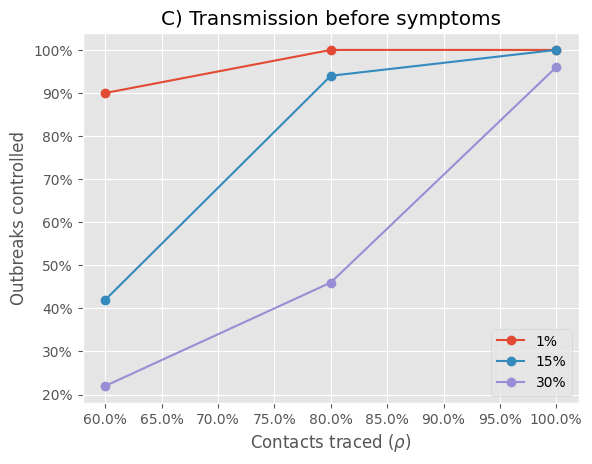

In [7]:
fig, ax = plt.subplots(1)

for transmission_before_symptoms_percentage in [1, 15, 30]:
    average_controlled_outbreaks = []
    for rho in rhos:
        average_controlled_outbreaks.append(test_scenario(rho, transmission_before_symptoms_percentage=transmission_before_symptoms_percentage)[0])
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=str(transmission_before_symptoms_percentage)+"%")

plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("C) Transmission before symptoms")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

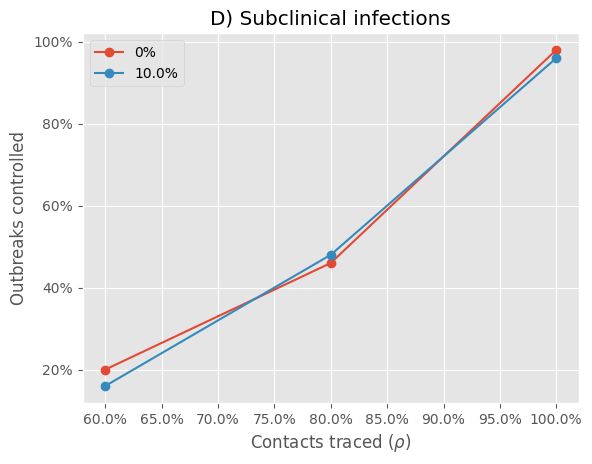

In [8]:
fig, ax = plt.subplots(1)

for subclinical_prob in [0, 0.1]:
    average_controlled_outbreaks = []
    for rho in rhos:
        average_controlled_outbreaks.append(test_scenario(rho, transmission_before_symptoms_percentage=transmission_before_symptoms_percentage)[0])
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=str(subclinical_prob*100)+"%")

plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("D) Subclinical infections")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

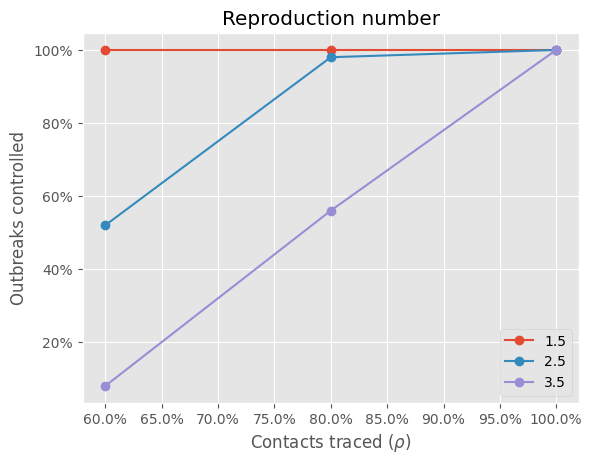

In [10]:
fig, ax = plt.subplots(1)

for R_0 in [1.5, 2.5, 3.5]:
    average_controlled_outbreaks = []
    for rho in rhos:
        average_controlled_outbreaks.append(test_scenario(rho, R_0 = R_0)[0])
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=R_0)

plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("Reproduction number")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()